In [ ]:
# Builtin modules
from itertools import chain
import random
import warnings
import sys
import os

# Images
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Deep learning
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
class AutomaticMapLabelling():
    
    def __init__(self, modelPath, full_chq, imagePath, width, height, channels):
        
        self.modelPath = modelPath
        self.full_chq = full_chq
        self.imagePath = imagePath
        self.IMG_WIDTH = width
        self.IMG_HEIGHT = height
        self.IMG_CHANNELS = channels
        self.model = self.U_net()
        
        
    def mean_iou(self, y_true, y_pred):
        
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)
    

    def U_net(self):
        
        # Build U-Net model
        inputs = Input((self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS))
        s = Lambda(lambda x: x / 255) (inputs)

        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
        c2 = Dropout(0.1) (c2)
        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
        c5 = Dropout(0.3) (c5)
        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
        c6 = Dropout(0.2) (c6)
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
        c8 = Dropout(0.1) (c8)
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
        c9 = Dropout(0.1) (c9)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[self.mean_iou])
        model.load_weights(self.modelPath)
        return model

    
    def prediction(self):
        
        img = cv2.imread(self.imagePath, 0)
        img = np.expand_dims(img, axis=-1)
        x_test = np.zeros((1, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
        # testimg = resize(img,(self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), mode='constant', preserve_range=True)
        x_test[0] = img
        preds_test = self.model.predict(x_test, verbose=1)
        
        preds_test = (preds_test > 0.5).astype(np.uint8)
        mask = preds_test[0]
        
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i][j] == 1:
                    mask[i][j] = 255
                else:
                    mask[i][j] = 0
                    
        merged_image = cv2.merge((mask, mask, mask))
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        for each_contour in contours:
            
            x, y, w, h = cv2.boundingRect(each_contour)
            cv2.rectangle(merged_image, (x, y), (x + w, y + h), (0, 0, 255), 4)
            plt.title("%s, %s, %s, %s" % (x, y, w, h))
            plt.imshow(merged_image)
            plt.show()

        return mask

1/1 [==============================] - 0s 489ms/step


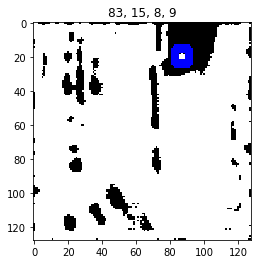

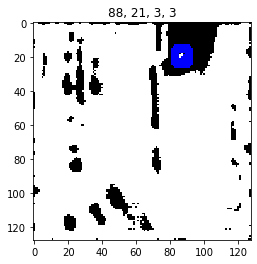

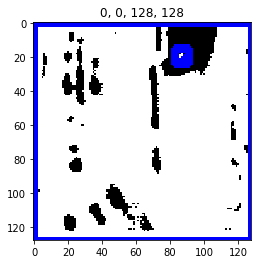

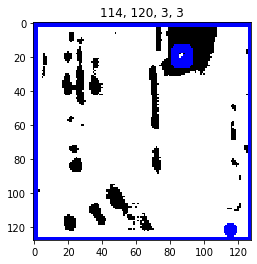

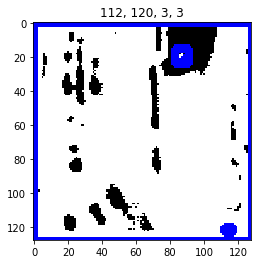

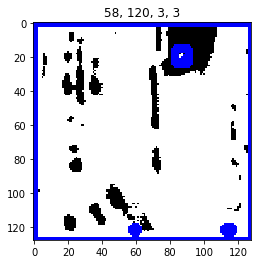

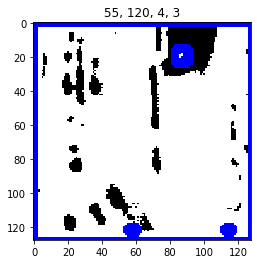

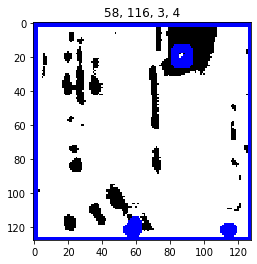

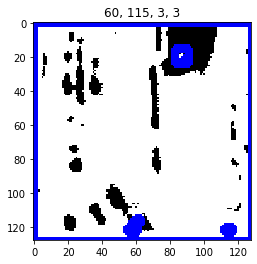

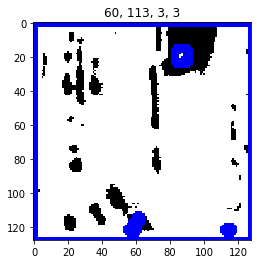

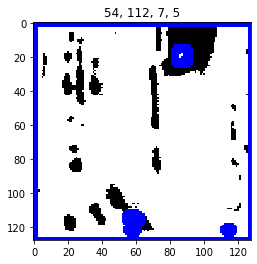

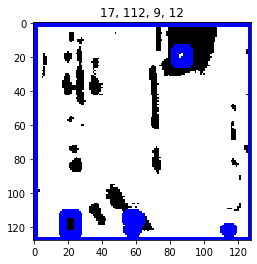

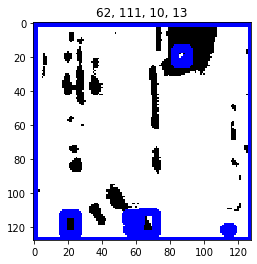

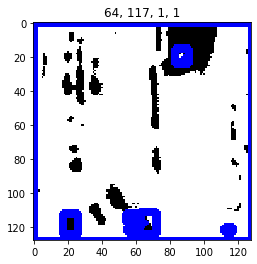

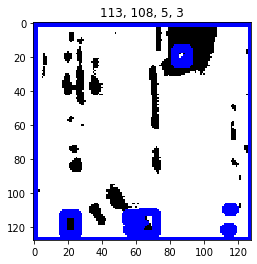

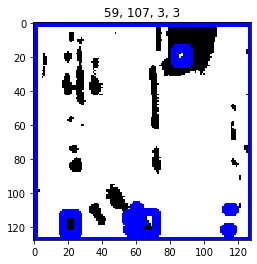

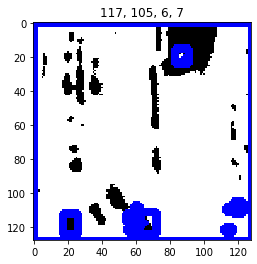

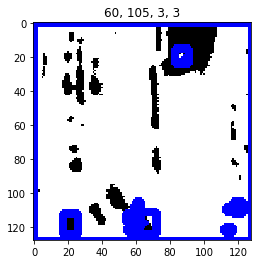

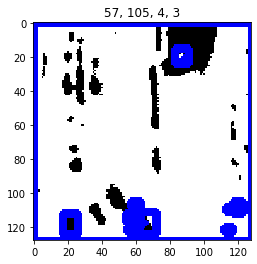

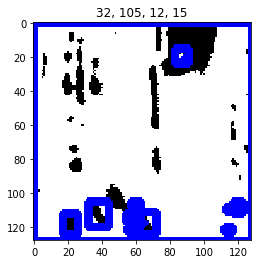

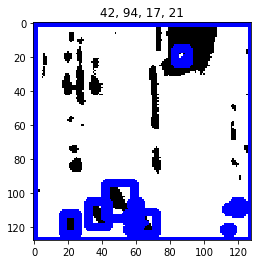

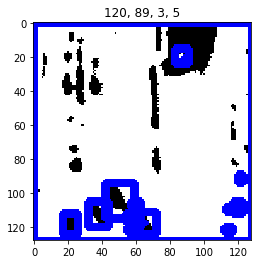

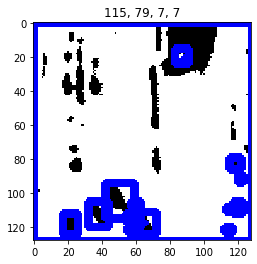

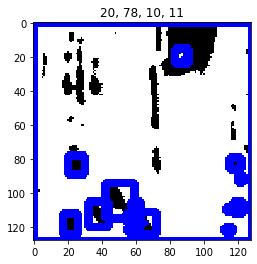

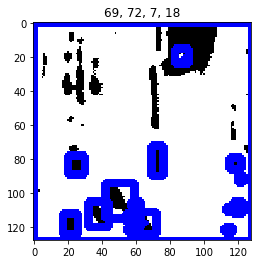

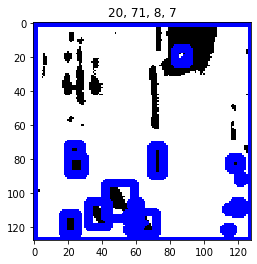

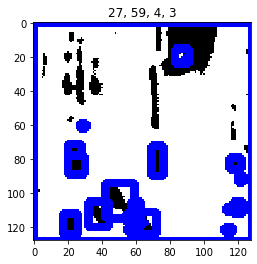

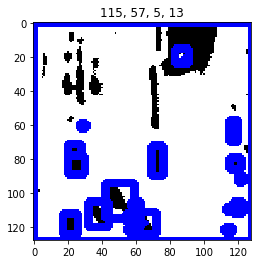

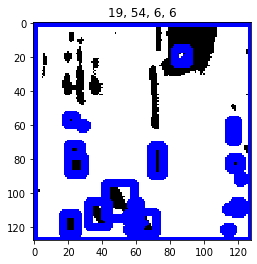

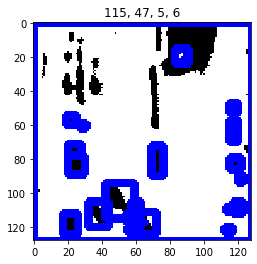

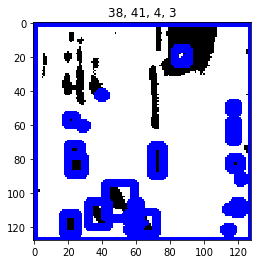

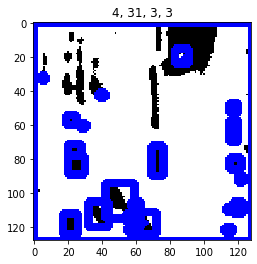

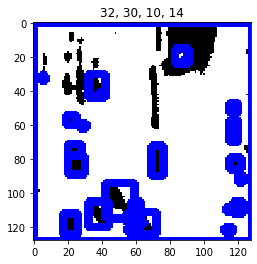

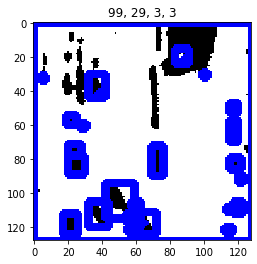

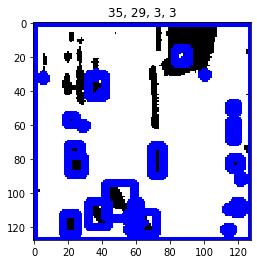

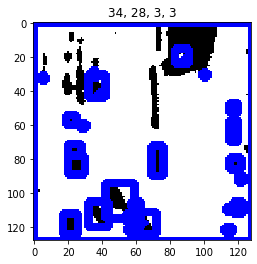

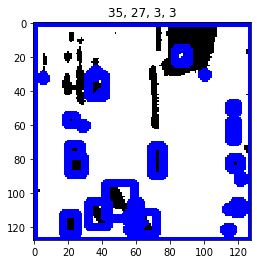

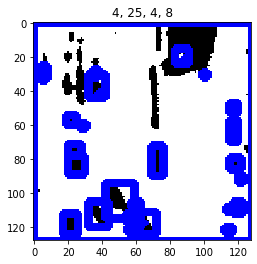

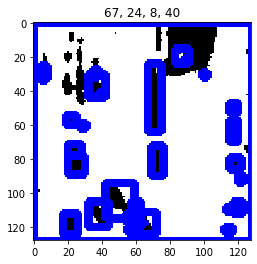

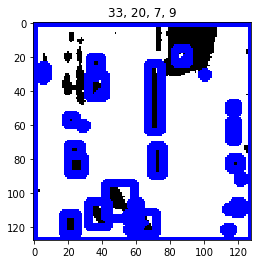

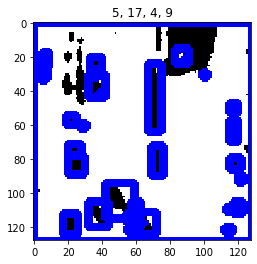

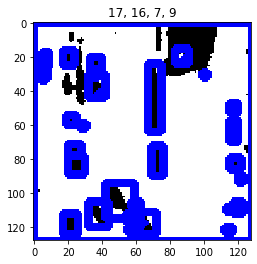

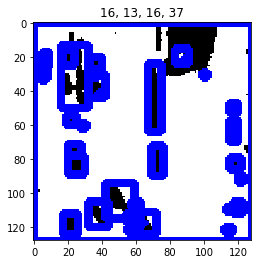

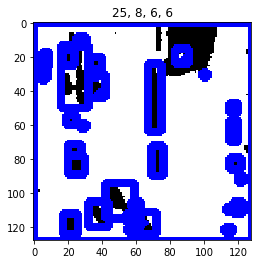

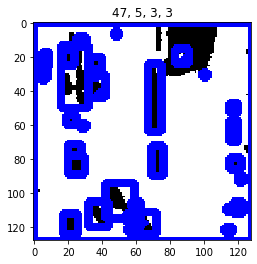

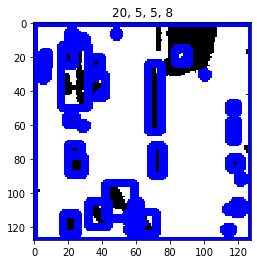

In [14]:
#Test image path , image size expected 128 x 128 x 3
test_image_name = "test/3.png"

#Model path
model_path = "test/model-dsbowl2018-1.h5"

AutomaticMapLabellingObj = AutomaticMapLabelling(model_path, True, test_image_name, 128, 128, 3)
predicted = AutomaticMapLabellingObj.prediction()
resized = cv2.resize(predicted, (128, 128), interpolation=cv2.INTER_AREA)

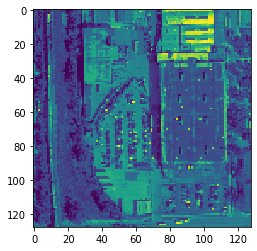

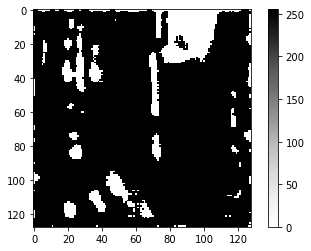

In [15]:
plt.imshow(cv2.imread(test_image_name, 0))
plt.show()

plt.imshow(resized, cmap='Greys')
plt.colorbar()
plt.show()

In [5]:
# # Code for resizing the test image to 128 x 128

# import cv2
# import os
# #Size of test input images should be 128
# #Please run the code to resize the test images
# #before testing 

# images_folder_path = "/U-Net/code/test/test_2D_satellite_images/"
# save_resized_image = "/U-Net/code/test/test_128/"
# for filename in os.listdir(images_folder_path):
#     image = cv2.imread(images_folder_path+filename)
#     resized_image = cv2.resize(image, (128, 128)) 
#     image_resized = save_resized_image + filename
#     print("resizing")
#     cv2.imwrite(image_resized,resized_image)